# **Proyecto: 🌍✈️ Sistema integrado de gestión y recomendación de viajes**
### **Materia:** Base de Datos 2025
## Alumno: Delfina González

Este trabajo simula la integración de datos diferentes bases de datos para modelar un sistema de gestión y recomendación de viajes. El sistema **almacena** datos de usuarios, destinos, hoteles, actividades, y realiza **recomendaciones** personalizadas a partir de datos distribuidos en **Neo4j, MongoDB y Redis.**

*En el mundo actual, los viajes y el turismo generan grandes cantidades de información sobre usuarios, destinos, alojamientos y actividades. Las empresas turísticas necesitan sistemas que no solo registren esta información, sino que también permitan realizar análisis, recomendaciones personalizadas y gestionar reservas de manera eficiente.*

### Funcionalidades:
 - Almacenar datos persistentes: información de usuarios,  historial de reservas, destinos turísticos, hoteles, actividades disponibles y precios asociados. 👉 MongoDB 
 - Gestionar datos temporales como usuarios conectados, datos de búsqueda o reservas en proceso. 👉 Redis
 - Relaciones de conocimiento entre usuarios, relaciones de usuarios y destinos (visitas). 👉 Neo4j.

### ⚙️ Elección y ventajas de las bases de datos utilizadas

El sistema combina **tres tecnologías de bases de datos complementarias**, cada una seleccionada por sus fortalezas específicas frente al tipo de información que maneja.

#### 🟢 MongoDB — Datos estructurados y semiestructurados
- **Ventaja principal:** Persistencia y flexibilidad en el manejo de documentos JSON, ideal para almacenar estructuras heterogéneas como usuarios, reservas, destinos o actividades.  
- **Permite** escalabilidad horizontal, consultas ágiles y fácil integración con aplicaciones en Python.  
- **Justificación:** los datos de usuarios y destinos poseen diferentes atributos y jerarquías, lo que hace más eficiente su almacenamiento en una base **NoSQL orientada a documentos**.

#### 🔴 Redis — Datos temporales y de alta frecuencia
- **Ventaja principal:** Al ser una base **en memoria**, ofrece una **velocidad de acceso extremadamente alta**, ideal para sesiones activas y procesos en tiempo real.  
- **Permite** gestionar usuarios conectados, caché de búsquedas y reservas pendientes, datos sin necesidad de almacenamiento estable y a largo plazo.  
- **Justificación:** su estructura tipo *key-value* simplifica la gestión de información volátil y evita sobrecargar las bases persistentes.

#### 🔵 Neo4j — Relaciones y conocimiento
- **Ventaja principal:** Modelo de datos **basado en grafos**, óptimo para representar y consultar relaciones complejas (como amistades o vínculos entre usuarios y destinos).  
- **Permite** ejecutar consultas semánticas eficientes mediante el lenguaje **Cypher**, identificando patrones y rutas dentro del grafo.  
- **Justificación:** el análisis de relaciones (por ejemplo, recomendaciones basadas en amigos o destinos visitados) requiere un modelo relacional dinámico y navegable, que Neo4j resuelve de forma más natural y eficiente que una base tabular.

➡️ En conjunto, esta arquitectura **poliglota** permite aprovechar lo mejor de cada tecnología:  
MongoDB para persistencia flexible, Redis para velocidad en operaciones temporales y Neo4j para análisis de relaciones y recomendaciones.


### Estructura del proyecto:

    - PARTE 0: "Configuración y conexiones"
    - PARTE A: "Carga inicial de Datasets"
    - PARTE B: "Consultas"
    - PARTE C: "Estadísticas y Gráficos"
    - PARTE D: "Modificaciones"
    - PARTE F: "Cierre de sesiones"

### 🔄 Mejoras agregadas en esta versión: Caché eficiente y consultas optimizadas

Para optimizar el rendimiento del sistema, se incorporó una **funcionalidad de caché centralizada y más eficiente** utilizando Redis, aplicada de dos formas complementarias:

1. **Caché de resultados de MongoDB**  
   - Cada consulta a colecciones de **MongoDB** (destinos, hoteles, actividades, reservas) se almacena en **Redis** de forma **estructurada como JSON**, permitiendo **recuperar los datos directamente** sin volver a consultar la base original.  
   - Esto reduce significativamente el **tiempo de respuesta** en consultas repetidas y evita sobrecargar MongoDB con solicitudes redundantes.  

**Beneficios principales de esta mejora:**
- 🔹 **Velocidad**: Acceso inmediato a consultas frecuentes gracias a Redis en memoria.  
- 🔹 **Eficiencia**: Menos consultas a MongoDB y menor carga sobre la base de datos persistente.  
- 🔹 **Consistencia**: Almacenamiento de resultados serializados en JSON garantiza compatibilidad y fácil integración con Pandas para análisis y visualización.  
- 🔹 **Flexibilidad**: Posibilidad de definir **expiración de cache (TTL)** para mantener datos actualizados según la naturaleza de la información.  

➡️ En conjunto, esta funcionalidad de **caché inteligente** mejora la **escalabilidad del sistema**, mantiene tiempos de respuesta bajos y permite ofrecer **recomendaciones personalizadas en tiempo real**, complementando la arquitectura poliglota del proyecto.

# PARTE 0: Configuración y conexiones

### 🧩 Importación de librerías

En este bloque se importan las librerías necesarias para todo el proyecto:  
- `os`, `time`, `dotenv`, `json` y `random` para tareas generales del sistema y manejo de datos.  
- `pandas` para manipulación tabular.  
- `matplotlib.pyplot` para generar visualizaciones.
- `neo4j`, `redis`, `pymongo`, para la conexión a cada base.
- Otras como: `IPython.display`, `datetime` y `numpy` se usaron en las consultas y gráficos.

👉 Esta sección prepara el entorno de trabajo para las etapas posteriores de carga, procesamiento y visualización de datos.

    Se cargan las bibliotecas
    Se establecen las conexiones con Neo4j, MongoDB y Redis.

In [125]:
import os, time
import json
from bson import ObjectId
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from dotenv import load_dotenv
from neo4j import GraphDatabase
from pymongo import MongoClient
import redis
from datetime import datetime
import numpy as np

# --- Configuración ---
load_dotenv()
print("Esperando servicios (5s)...")
time.sleep(5)

NEO4J_HOST = "bolt://neo4j:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD", "neo4j123")
MONGO_URI = f"mongodb://{os.getenv('MONGO_INITDB_ROOT_USERNAME', 'admin')}:{os.getenv('MONGO_INITDB_ROOT_PASSWORD', 'admin123')}@mongo:27017/"
REDIS_HOST = os.getenv("REDIS_HOST", "redis")
REDIS_PORT = int(os.getenv("REDIS_PORT", 6379))
REDIS_PASSWORD = os.getenv("REDIS_PASSWORD", "redis123")

print("Variables cargadas y hosts definidos.")

# --- Conexiones ---
def connect_neo4j():
    """
    Establece la conexión con Neo4j y devuelve un driver.

    Args:
        uri (str): URI del servidor Neo4j (ej. "bolt://localhost:7687").
        user (str): Usuario de Neo4j.
        password (str): Contraseña.

    Returns:
        neo4j.Driver: Driver para ejecutar consultas Cypher.
    """
    try:
        driver = GraphDatabase.driver(NEO4J_HOST, auth=(NEO4J_USER, NEO4J_PASSWORD))
        with driver.session() as s:
            s.run("RETURN 1")
        print("✅ Conectado a Neo4j")
        return driver
    except Exception as e:
        print(f"❌ Error al conectar a Neo4j: {e}")
        return None

def connect_mongo():
    """
    Establece la conexión con MongoDB y devuelve la base de datos seleccionada.

    Esta función centraliza la creación del cliente, manejo de credenciales
    y selección de base de datos, para que el resto del código use siempre
    la misma instancia.

    Args:
        uri (str): URI del servidor MongoDB.
        db_name (str): Nombre de la base de datos a usar.
        user (str, optional): Usuario de autenticación. Defaults to None.
        password (str, optional): Contraseña. Defaults to None.

    Returns:
        Database | None: Objeto Database de PyMongo o None si la conexión falla.
    """    
    try:
        client = MongoClient(MONGO_URI)
        client.server_info()
        print("✅ Conectado a MongoDB")
        return client
    except Exception as e:
        print(f"❌ Error al conectar a MongoDB: {e}")
        return None

def connect_redis():
    """
    Crea un cliente de Redis y lo devuelve.

    Esta función encapsula la creación del cliente, permitiendo configurar 
    fácilmente parámetros como decodificación automática o uso de contraseña.

    Args:
        host (str): Dirección del servidor Redis.
        port (int): Puerto del servidor.
        password (str, optional): Contraseña. Defaults to None.
        decode_responses (bool, optional): Si True, Redis devuelve strings en lugar de bytes. Defaults to False.

    Returns:
        redis.Redis | None: Cliente Redis o None si la conexión falla.
    """
    try:
        r = redis.Redis(
            host=REDIS_HOST,
            port=REDIS_PORT,
            password=REDIS_PASSWORD,
            decode_responses=True
        )
        r.ping()
        print("✅ Conectado a Redis")
        return r
    except Exception as e:
        print(f"❌ Error al conectar a Redis: {e}.")
        return None

neo4j_driver = connect_neo4j()
mongo_client = connect_mongo()
redis_client = connect_redis()

DB_NAME = "base_proyecto"
db = mongo_client[DB_NAME] if mongo_client else None

# Cargo constantes
DESTINO_ID_A_CIUDAD = {
    1: "Bariloche",
    2: "Cancún",
    3: "Madrid",
    4: "Roma",
    5: "Mendoza",
    6: "Ushuaia",
    7: "Puerto Iguazú",
    8: "Salta",
    9: "Río de Janeiro",
    10: "Punta Cana",
    11: "El Calafate",
    12: "Santiago",
    13: "Nueva York",
    14: "Tucumán",
    15: "Mar del Plata",
    16: "San Salvador de Jujuy"
}

CIUDAD_A_DESTINO_ID = {v: k for k, v in DESTINO_ID_A_CIUDAD.items()}

Esperando servicios (5s)...
Variables cargadas y hosts definidos.
✅ Conectado a Neo4j
✅ Conectado a MongoDB
✅ Conectado a Redis


# PARTE A: Carga inicial de Datasets

## 1. Carga de Datos Base y Limpieza

### 🗂️ Configuración de archivos de datos

Aquí se definen las rutas y los archivos requeridos por el sistema (usuarios, destinos, hoteles, actividades y reservas).  
También se inicializan estructuras (`data`, `missing`) para verificar si todos los archivos están disponibles.

Se asegura la limpieza de las bases para mantener la integridad de los datos en cada ejecución

👉 Esta verificación inicial evita errores en etapas posteriores al asegurar que la base de datos cuente con todos los insumos.


In [126]:
DATA_DIR = "data"
required_files = ["usuarios.json", "destinos.json", "hoteles.json", "actividades.json", "reservas.json"]
data = {}
missing = []

for f_name in required_files:
    f_path = os.path.join(DATA_DIR, f_name)
    if os.path.exists(f_path):
        with open(f_path, encoding="utf-8") as f:
            data[f_name.split('.')[0]] = json.load(f)
    else:
        missing.append(f_name)

if missing:
    print(f"⚠️ No se encontraron los siguientes archivos en '{DATA_DIR}/': {', '.join(missing)}")
    print("Por favor, asegúrate de tener todos los archivos JSON necesarios.")
else:
    print("✅ Archivos de datos cargados correctamente.")
    print("-" * 30)

# --- Limpieza de Bases de Datos ---
if neo4j_driver:
    with neo4j_driver.session() as s:
        s.run("MATCH (n) DETACH DELETE n")
        print("✅ Neo4j limpio.")

if mongo_client:
    mongo_client.drop_database(DB_NAME)
    print(f"✅ MongoDB ({DB_NAME}) limpio.")

if redis_client:
    for key in redis_client.scan_iter("tp_*"): 
        redis_client.delete(key)
    print("✅ Claves temporales de Redis limpias.")


✅ Archivos de datos cargados correctamente.
------------------------------
✅ Neo4j limpio.
✅ MongoDB (base_proyecto) limpio.
✅ Claves temporales de Redis limpias.


## 2. Carga en MongoDB, Redis y Neo4j
### Distribución de datos:

    - **MongoDB:** Usuarios, Destinos, Hoteles, Actividades y Reservas Concretadas.
    - **Redis:** Reservas Pendientes (temporal), Usuarios Conectados (set) y Caché de búsquedas.
    - **Neo4j:** Nodos (Usuarios, Destinos) y Relaciones (Amigos y Familiares)

### 💾 Carga de datos estables y dinámicos

En este bloque se realiza la carga de los datos en la base MongoDB.  
Se insertan colecciones separadas (`usuarios`, `destinos`, `hoteles`, `actividades`,`reservas`) desde los archivos JSON previamente validados.

Luego, se generan los datos temporales de `conexión de usuarios`, `caché de búsqueda` y `reservas pendientes` de forma aleatoria para cargarlos en Redis.
- hash → estructura compleja con expiración (**reservas, caché**). Permiten almacenar múltiples campos estructurados dentro de una única clave (campo:valor), manteniendo la reserva o la búsqueda como un objeto compacto, fácil de leer y actualizar.
- set → colección única y dinámica (**usuarios conectados**). Permiten manejar colecciones sin duplicados, con operaciones muy eficientes de pertenencia, agregado y tamaño del conjunto.

Por último, se crean los `nodos` que utilizaremos para las relaciones de Neo4j (`usuarios` y `destinos`), las `relaciones sociales(amigos/familia)` y las `visitas` con un algotirmo aleatorio pero coherente y basado en los Datasets disponibles.

👉 Esta etapa constituye la **persistencia de datos**: garantiza que la información quede almacenada en la base para las consultas posteriores.


In [127]:
if data:
    # Carga en MongoDB (Datos permanentes)
    db.usuarios.insert_many(data["usuarios"])
    db.destinos.insert_many(data["destinos"])
    db.hoteles.insert_many(data["hoteles"])
    db.actividades.insert_many(data["actividades"])
    
    # Filtrar Reservas: Cargo solo las que tienen estado CONFIRMADO a MongoDB
    reservas_concretadas = [
        r for r in data["reservas"] 
        if r["estado"] == "Confirmada"
    ]
    if reservas_concretadas:
        db.reservas.insert_many(reservas_concretadas)
    
    print("✅ Datos base y Reservas concretadas cargados en MongoDB.")

    # Carga en Redis (Datos temporales: Caché y Reservas Pendientes)
    if redis_client:
        redis_client.delete("viajes_usuarios_conectados")
        redis_client.delete("viajes_cache:busquedas")
        # Reservas Temporales (Pendientes). Se crea un hash por reserva pendiente con expiración aleatoria entre 30 y 120 segundos.
        reservas_pendientes = [
            r for r in data["reservas"] 
            if r["estado"] == "Pendiente"
        ]
        for r in reservas_pendientes:
            clave_pend = f"viajes_reserva:pendiente:{r['reserva_id']}"
            r_str = {k: str(v) for k, v in r.items()}
            redis_client.hset(clave_pend, mapping=r_str)
            redis_client.expire(clave_pend, random.randint(30, 120))
        print(f"✅ {len(reservas_pendientes)} Reservas Pendientes cargadas en Redis.")

        # Usuarios Conectados. Se crea un set con entre 5 y 25 usuarios aleatorios.
        usuarios_conectados = random.sample([usu["nombre"] for usu in data["usuarios"]], k=random.randint(5, 25))
        for nombre in usuarios_conectados:
            redis_client.sadd("viajes_usuarios_conectados", nombre)
        print(f"✅ {len(usuarios_conectados)} Usuarios Conectados cargados en Redis.")

    # --- 3️⃣ Búsquedas en Caché (hashes con expiración) ---

    # Ciudades, países y tipos disponibles desde los datos
    ciudades_populares = [d["ciudad"] for d in data["destinos"]]
    paises_populares = sorted(set([d["pais"] for d in data["destinos"]]))
    tipos_populares = sorted(set([d["tipo"] for d in data["destinos"]]))

    # Búsquedas simuladas
    num_busquedas = random.randint(50, 200)

    for _ in range(num_busquedas):
        tipo_busqueda = random.choice(["ciudad", "pais", "tipo", "precio"])
        
        # --- Determinar valor y consulta según el tipo ---
        if tipo_busqueda == "ciudad":
            valor = random.choice(ciudades_populares)
            clave_cache = f"viajes_cache:busqueda:ciudad:{valor.lower()}"
            datos_busqueda = list(db.destinos.find({"ciudad": valor}, {"_id": 0}))
            
        elif tipo_busqueda == "pais":
            valor = random.choice(paises_populares)
            clave_cache = f"viajes_cache:busqueda:pais:{valor.lower().replace(' ', '_')}"
            datos_busqueda = list(db.destinos.find({"pais": valor}, {"_id": 0}))
            
        elif tipo_busqueda == "tipo":
            valor = random.choice(tipos_populares)
            clave_cache = f"viajes_cache:busqueda:tipo:{valor.lower()}"
            datos_busqueda = list(db.destinos.find({"tipo": valor}, {"_id": 0}))
            
        else:  # tipo_busqueda == "precio"
            valor = random.randint(50, 300)  # rango de precios simulado
            clave_cache = f"viajes_cache:busqueda:precio:menor_{valor}"
            datos_busqueda = list(db.hoteles.find({"precio": {"$lt": valor}}, {"_id": 0}))
        
        # --- Construir y guardar los datos en Redis ---
        busqueda_data = {
            "tipo_busqueda": tipo_busqueda,
            "valor": valor,
            "timestamp": datetime.now().isoformat(timespec="seconds"),
            "resultados_encontrados": json.dumps(datos_busqueda, ensure_ascii=False)
        }

        redis_client.hset(clave_cache, mapping=busqueda_data)
        redis_client.expire(clave_cache, random.randint(90, 360))  # Expira entre 1,5 y 6 min

    # Carga en Neo4j (Nodos y Relaciones)
    # Nodos 
    if neo4j_driver:
        with neo4j_driver.session() as s:
            # Restricciones de unicidad, para asegurar la integridad y consistencia de los datos
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (u:Usuario) REQUIRE u.usuario_id IS UNIQUE")
            s.run("CREATE CONSTRAINT IF NOT EXISTS FOR (d:Destino) REQUIRE d.destino_id IS UNIQUE")

            # Nodos: Usuario y Destino. Evita duplicados y garantiza consistencia si se corre la carga más de una vez.
            for u in data["usuarios"]:
                s.run("MERGE (u:Usuario {usuario_id:$id, nombre:$nombre})", id=u["usuario_id"], nombre=u["nombre"])
            for d in data["destinos"]:
                s.run("MERGE (d:Destino {destino_id: $id}) SET d.ciudad = $ciudad, d.precio_base = $precio_base", 
                      id=d["destino_id"], ciudad=d["ciudad"], precio_base=d["precio_base"])

    # Relaciones VISITÓ basadas en Reservas Confirmadas Pasadas
    hoy = datetime.now().date()
    reservas_validas = [
        r for r in data.get("reservas", [])
        if r.get("estado") == "Confirmada" and datetime.strptime(r["fecha_reserva"], "%Y-%m-%d").date() <= hoy
        ]
  
    with neo4j_driver.session() as s:
        if reservas_validas not in (None, []):
            for r in reservas_validas:
                u_id = r["usuario_id"]
                d_id = r["destino_id"]
                s.run(
                        """
                        MATCH (u:Usuario {usuario_id:$u}), (d:Destino {destino_id:$d})
                        MERGE (u)-[:VISITO]->(d)
                        """,
                        u=u_id, d=d_id  
                    )
            print(f"✅ {len(reservas_validas)} relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.")
            # Mostrar las reservas válidas en un DataFrame
            df_visito = pd.DataFrame(reservas_validas)
            df_visito['Nombre Usuario'] = df_visito['usuario_id'].map({u["usuario_id"]: u["nombre"] for u in data["usuarios"]})
            df_visito['Ciudad Destino'] = df_visito['destino_id'].map(DESTINO_ID_A_CIUDAD)
            display(df_visito[["reserva_id", "fecha_reserva", "estado", "Nombre Usuario", "Ciudad Destino"]].sort_values("Nombre Usuario"))
        else:
            print("⚠️ No hay reservas confirmadas pasadas para crear relaciones VISITÓ.")

        # Relaciones Sociales (AMIGO_DE, FAMILIAR_DE) - Evitando duplicados e inversas
        tipos_relacion = ["AMIGO_DE", "FAMILIAR_DE"] 
            
        # Intentamos crear el triple de relaciones que usuarios de forma aleatoria
        # Se evita crear relaciones entre el mismo usuario y ya existentes (ej. amigo y familiar a la vez)
        relaciones_creadas = []

        for _ in range(len(data["usuarios"]) * 3):
                u1 = random.choice(data["usuarios"])
                u2 = random.choice(data["usuarios"])
                u1_id = u1["usuario_id"]
                u2_id = u2["usuario_id"]
                tipo = random.choice(tipos_relacion)


                # 1. Aseguramos que los IDs sean diferentes y que no existan relaciones previas.
                if u1_id == u2_id:
                    continue
               
                query = f"""
                MATCH (u1:Usuario {{usuario_id: $u1_id}})
                MATCH (u2:Usuario {{usuario_id: $u2_id}})
                
                WHERE NOT (u1)-[:AMIGO_DE|FAMILIAR_DE]-(u2)
                
                MERGE (u1)-[:{tipo}]->(u2)
                """
                # Ejecutar la query con los parámetros
                resultado_relaciones = s.run(query, u1_id=u1_id, u2_id=u2_id)

                if resultado_relaciones is not None:
                # Almacenar los datos de la relación *creada*
                    relaciones_creadas.append({
                        "Usuario 1": u1["nombre"],
                        "Usuario 2": u2["nombre"],
                        "Tipo de Relación": tipo
                    })
        # Asegurar bidireccionalidad para AMIGO_DE (si A es amigo de B, entonces B es amigo de A)
        query_bidireccional = """
            MATCH (a:Usuario)-[:AMIGO_DE]->(b:Usuario)
            WHERE NOT (b)-[:AMIGO_DE]->(a)
            MERGE (b)-[:AMIGO_DE]->(a)
            RETURN COUNT(*) AS relaciones_creadas
            """

        try:
            result = s.run(query_bidireccional).single()
            cantidad_creadas = result["relaciones_creadas"] if result else 0
        except Exception as e:
            print("⚠️ Error al asegurar bidireccionalidad:", e)

        df_relaciones = pd.DataFrame(relaciones_creadas)

        print(f"✅ {df_relaciones.shape[0]} Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.")

        pd.set_option('display.max_rows', 100)
        pd.set_option('display.max_colwidth', 500)

        display(df_relaciones.sort_values(["Tipo de Relación", "Usuario 1"]).reset_index(drop=True))

✅ Datos base y Reservas concretadas cargados en MongoDB.
✅ 13 Reservas Pendientes cargadas en Redis.
✅ 25 Usuarios Conectados cargados en Redis.
✅ 30 relaciones VISITÓ creadas en Neo4j basadas en reservas confirmadas pasadas.


,reserva_id,fecha_reserva,estado,Nombre Usuario,Ciudad Destino
29,50,2025-04-20,Confirmada,Agustina Benítez,Río de Janeiro
15,25,2025-03-01,Confirmada,Agustina Benítez,Tucumán
2,5,2024-06-25,Confirmada,Ana Torres,Mendoza
12,18,2024-08-25,Confirmada,Andrés Pereyra,Puerto Iguazú
27,47,2025-01-25,Confirmada,Bárbara Nuñez,Ushuaia
24,41,2025-07-15,Confirmada,Carla Gómez,Bariloche
18,31,2025-09-10,Confirmada,Delfina Giménez,Mendoza
11,17,2024-07-20,Confirmada,Diego Romero,Ushuaia
8,11,2024-01-01,Confirmada,Emilia Ríos,Bariloche
19,32,2025-10-15,Confirmada,Ezequiel Blanco,Ushuaia


✅ 148 Relaciones sociales (AMIGO_DE/FAMILIAR_DE) creadas.


,Usuario 1,Usuario 2,Tipo de Relación
0,Agustina Benítez,Camilo Arias,AMIGO_DE
1,Andrés Pereyra,Ezequiel Blanco,AMIGO_DE
2,Bárbara Nuñez,Lourdes Ferrero,AMIGO_DE
3,Camilo Arias,Facundo Silva,AMIGO_DE
4,Camilo Arias,Milagros Herrera,AMIGO_DE
...,...,...,...
143,Santiago Castro,Carla Gómez,FAMILIAR_DE
144,Sebastián Maradona,Horacio Quiroga,FAMILIAR_DE
145,Sofía Morales,Juan López,FAMILIAR_DE
146,Sofía Morales,Ramiro Chávez,FAMILIAR_DE


# PARTE B: Funciones y Consultas

### Definición de las funciones *helper* y las consultas específicas para cada base de datos.

Se definen funciones genéricas que ejecutan consultas sobre Neo4j y devuelven los resultados en formato de lista o DataFrame.  
Estas funciones centralizan la conexión y el manejo de errores, facilitando la reutilización en distintos análisis.

Se implementaron funciones *helper* que centralizan la **consulta a MongoDB** y el **cache en Redis**.  

- Primero se verifica si los datos existen en Redis; si no, se consulta MongoDB y se guarda el resultado en caché.  
- Esto permite **reutilizar código**, mantener consistencia y mejorar la **eficiencia** en las consultas y búsquedas filtradas.  

Se incluyen los procesamientos de los datos para cada consulta, con el objetivo de luego poder tener una visualización de los resultados más limpia y ordenada.

👉 Esta decisión mejora la **modularidad y mantenibilidad** del código, al concentrar la lógica de conexión y consulta en un solo lugar.


### 1) ⚙️ Funciones para simplificar las Query en las consultas

Explicación del uso Diferenciado de Redis. Redis se usa en el proyecto con dos propósitos diferentes:

- **Almacenar datos operativos temporales (usuarios conectados, reservas en proceso).**

- **Actuar como cache para resultados de consultas de MongoDB.**

Por ese motivo hay distintos tipos de funciones:

    📌 query_redis() → gestión de datos operativos (sets, keys activas, patrones).

    📌 query_redis_cache() → sistema de cache.

    📌 query_cache_mongo() → relación Mongo–Redis, pipeline para el procesamiento híbrido.

In [128]:
#----------FUNCIONES AUXILIARES ------------------------------------------------------------

def query_neo4j(query, params=None):
    """
    Ejecuta una consulta Cypher en Neo4j y devuelve los resultados como una lista 
    de diccionarios, facilitando su uso con Pandas o procesamiento posterior.

    Esta función actúa como helper general para todas las consultas Neo4j del 
    proyecto, abstrae la apertura de sesión y centraliza el manejo de errores.

    Args:
        query (str): Consulta Cypher a ejecutar.
        params (dict, optional): Parámetros para la consulta. Defaults to None.

    Returns:
        list[dict]: Resultados de la consulta convertidos a diccionarios.
    """
    if not neo4j_driver:
        return []

    with neo4j_driver.session() as s:
        try:
            result = s.run(query, **(params or {}))
            # Convertir cada registro en dict (para Pandas)
            return [dict(r) for r in result]
        except Exception as e:
            print("⚠️ Error en query_neo4j:", e)
            return []

def query_mongo(collection_name, query):
    """
    Ejecuta una consulta sencilla en MongoDB sobre una colección específica 
    y devuelve los documentos encontrados como una lista de diccionarios.

    Esta función se usa para consultas directas a Mongo que no requieren cache 
    ni procesamiento especial.

    Args:
        collection_name (str): Nombre de la colección a consultar.
        query (dict): Filtros de la consulta MongoDB.

    Returns:
        list[dict]: Documentos encontrados.
    """
    
    if db is None: 
        return []
        
    return list(db[collection_name].find(query))

def query_redis(pattern):
    """
    Consulta Redis buscando claves que coincidan con un patrón y devuelve 
    los resultados en un formato uniforme apto para Pandas.

    Esta función está pensada para consultar **datos cuyo origen es Redis** 
    (usuarios conectados, reservas temporales, contadores, etc.). 
    No forma parte del sistema de cache, sino del uso operacional de Redis 
    como base de datos en memoria.

    Soporta automáticamente los tipos más comunes:
    - Hashes  → se devuelven como diccionarios
    - Sets    → se devuelven como diccionarios de usuarios
    - Strings → se devuelven como pares clave-valor

    Args:
        pattern (str): Patrón de claves Redis a buscar (ej. "usuarios:*").

    Returns:
        list[dict]: Lista de estructuras homogéneas representando el contenido de Redis.
    """
    if redis_client is None:
        print("⚠️ Redis no está conectado.")
        return []

    results = []

    try:
        keys = redis_client.keys(pattern)

        for key in keys:
            tipo = redis_client.type(key)

            if tipo == "hash":
                data = redis_client.hgetall(key)
                results.append(data)
            elif tipo == "set":
                # Convertimos en una lista de usuarios individuales
                users = list(redis_client.smembers(key))
                for u in users:
                    results.append({"Usuario Conectado": u})
            elif tipo == "string":
                results.append({key: redis_client.get(key)})
            else:
                print(f"⚠️ Clave {key} es de tipo {tipo} (no manejado)")
                continue

        return results

    except Exception as e:
        print(f"❌ Error al consultar Redis: {e}")
        return []

def query_redis_cache(pattern):
    """
    Lee datos almacenados en Redis utilizados como **cache de consultas Mongo**.
    
    A diferencia de `query_redis`, esta función está especializada en leer 
    valores almacenados como JSON en Redis y parsearlos automáticamente para 
    devolver diccionarios listos para su uso con DataFrames.

    Esta función NO consulta Mongo. Solo interpreta y reconstruye el cache.

    Args:
        pattern (str): Patrón o clave específica donde se guardó el cache.

    Returns:
        list[dict]: Datos decodificados desde Redis listos para procesar.
    """
    if redis_client is None:
        print("⚠️ Redis no está conectado.")
        return []

    results = []

    try:
        keys = redis_client.keys(pattern)
        for key in keys:
            key_str = key.decode("utf-8") if isinstance(key, bytes) else str(key)
            tipo = redis_client.type(key_str)
            
            if tipo == b"hash" or tipo == "hash":
                data = redis_client.hgetall(key_str)
                for v in data.values():
                    v_dec = v.decode("utf-8") if isinstance(v, bytes) else v
                    try:
                        results.append(json.loads(v_dec))
                    except json.JSONDecodeError:
                        results.append({"valor": v_dec})
            
            elif tipo == b"set" or tipo == "set":
                members = redis_client.smembers(key_str)
                for m in members:
                    m_dec = m.decode("utf-8") if isinstance(m, bytes) else m
                    results.append({"_clave": key_str, "valor": m_dec})

            elif tipo == b"string" or tipo == "string":
                val = redis_client.get(key_str)
                val_dec = val.decode("utf-8") if isinstance(val, bytes) else val
                try:
                    results.append(json.loads(val_dec))
                except json.JSONDecodeError:
                    results.append({key_str: val_dec})

            else:
                print(f"⚠️ Tipo Redis no manejado para clave {key_str}: {tipo}")

        return results

    except Exception as e:
        print(f"❌ Error al consultar Redis: {e}")
        return []


# ------------------------------- 
def query_cache_mongo(collection_name, query, clave_cache, expiracion=300):
    """
    Sistema completo de cache Redis → Mongo.

    Esta función implementa el patrón:
        1) Intentar obtener el resultado desde Redis (via query_redis_cache)
        2) Si no existe, consultar MongoDB
        3) Serializar el resultado en JSON y almacenarlo en Redis
        4) Devolver un DataFrame final

    Esto permite acelerar consultas costosas o frecuentemente repetidas.

    Args:
        collection_name (str): Colección MongoDB a consultar.
        query (dict): Filtros de la consulta MongoDB.
        clave_cache (str): Clave única donde se guardará el resultado cacheado.
        expiracion (int, optional): Tiempo de expiración del cache en segundos.
                                    Defaults to 300.

    Returns:
        pandas.DataFrame: Resultados obtenidos desde Redis o Mongo.
    """
    # 1️⃣ Revisar Redis primero
    datos_cache = query_redis_cache(clave_cache)
    if datos_cache:
        df = pd.DataFrame(datos_cache)
        return df

    # 2️⃣ No estaba en Redis → consultar Mongo
    datos_mongo = query_mongo(collection_name, query)
    if not datos_mongo:
        return pd.DataFrame()

    # 3️⃣ Convertir ObjectId a str
    for doc in datos_mongo:
        for k, v in doc.items():
            if isinstance(v, ObjectId):
                doc[k] = str(v)

    df = pd.DataFrame(datos_mongo)

    # 4️⃣ Guardar en Redis como hash JSON (clave = índice)
    for i, row in df.iterrows():
        redis_client.hset(clave_cache, i, json.dumps(row.to_dict()))
    redis_client.expire(clave_cache, expiracion)

    return df

### 2) Funciones de las consultas

In [129]:

# --- PUNTO A -------------------------------------------------------------------------------

def consulta_a_usuarios_bariloche():
    """
    Consulta 2.a:
    Devuelve los usuarios que visitaron la ciudad de Bariloche.

    Backend: Neo4j
    Retorna:
        DataFrame con columnas ['Usuario', 'ID Usuario'].
    """
    q = "MATCH (u:Usuario)-[:VISITO]->(d:Destino {ciudad:'Bariloche'}) RETURN u.nombre AS nombre, u.usuario_id AS id"
    pd_a = pd.DataFrame(query_neo4j(q)).rename(columns={0: "Usuario", 1: "ID Usuario"})
    return pd_a

# --- PUNTO B -------------------------------------------------------------------------------

def obtener_amigos_y_destinos_visitados(nombre_referencia):
    """
    Obtiene todos los amigos de un usuario y los destinos que visitaron.

    Si un amigo no tiene destinos registrados, se devuelve 'Ninguno'.
    Backend: Neo4j

    Retorna:
        DataFrame con columnas ['Amigo/a', 'Destinos Visitados'].
    """

    q = f"""
    MATCH (user:Usuario {{nombre: '{nombre_referencia}'}})-[:AMIGO_DE]-(amigo:Usuario)
    OPTIONAL MATCH (amigo)-[:VISITO]->(d:Destino)
    RETURN 
        amigo.nombre AS Amigo,
        collect(DISTINCT coalesce(d.ciudad, "Ninguno")) AS DestinosVisitados
    """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron amigos o destinos para {nombre_referencia}.")
        return pd.DataFrame()
    df_amigos = pd.DataFrame(resultados).rename(columns={0: "Amigo/a", 1: "Destinos Visitados"})

        
    return df_amigos


def consulta_b_amigos_destinos(nombre):
    """
    Consulta 2.b:
    Devuelve amigos del usuario especificado que hayan visitado destinos
    que él también visitó.

    Backend: Neo4j
    Retorna:
        DataFrame con columnas ['Amigo', 'Destino Común'].
    """

    if not nombre or not isinstance(nombre, str):
        print("⚠️ El nombre proporcionado no es válido.")
        return pd.DataFrame()

    q = """
    MATCH (u:Usuario {nombre: $nombre})-[:AMIGO_DE]->(amigo:Usuario)
    MATCH (u)-[:VISITO]->(d:Destino)<-[:VISITO]-(amigo)
    RETURN amigo.nombre AS Amigo, d.ciudad AS `Destino Común`
    ORDER BY amigo.nombre, `Destino Común`
    """

    try:
        resultados = query_neo4j(q, {"nombre": nombre})
        df_b = pd.DataFrame(resultados)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if df_b.empty:
        print(f"⚠️ No se encontraron amigos que hayan visitado destinos comunes con {nombre}.")
    else:
        print(f"✅ Amigos de {nombre} que visitaron destinos comunes:")
        
    return df_b


# --- PUNTO C -------------------------------------------------------------------------------

def consulta_c_sugerir_destinos(nombre, preferencia_de_búsqueda):
    """
    Consulta 2.c:
    Sugiere destinos que no fueron visitados por el usuario ni sus amigos.
    Permite ordenar por:
        - 'popularidad'
        - 'mayor precio'
        - 'menor precio'

    Backend: Neo4j
    Retorna:
        DataFrame con sugerencias y el criterio aplicado.
    """

    preferencia = preferencia_de_búsqueda.strip().lower() if preferencia_de_búsqueda else "popularidad"
    
    # --- Estructura para la EXCLUSIÓN (común a todas las consultas) ---
    
    exclusion_base = f"""
    MATCH (u:Usuario {{nombre:'{nombre}'}})
    OPTIONAL MATCH (u)-[:VISITO]->(d_user:Destino)
    OPTIONAL MATCH (u)-[:AMIGO_DE]->(p:Usuario)-[:VISITO]->(d_friend:Destino)
    WITH u, collect(DISTINCT d_user) + collect(DISTINCT d_friend) AS no_sugerir_list
    """
    
    if preferencia == "mayor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    elif preferencia == "menor precio":
        q = exclusion_base + """
        MATCH (d:Destino)
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, d.precio_base AS Precio
        ORDER BY Precio ASC, Destino_Sugerido ASC
        LIMIT 3
        """ 

    else:  # Popularidad
        preferencia = "popularidad"
        q = exclusion_base + """
        MATCH (d:Destino)<-[:VISITO]-(otros:Usuario)
        WITH no_sugerir_list, d, count(otros) AS popularidad
        WHERE NOT d IN no_sugerir_list
        RETURN d.ciudad AS Destino_Sugerido, popularidad AS Valoracion
        ORDER BY popularidad DESC, Destino_Sugerido ASC
        LIMIT 3
        """

    try:
        resultados = query_neo4j(q)
    except Exception as e:
        print("⚠️ Error ejecutando consulta Neo4j:", e)
        return pd.DataFrame()

    if not resultados:
        print(f"⚠️ No se encontraron destinos sugeridos para {nombre}.")
        return pd.DataFrame()

    df_c = pd.DataFrame(resultados)

    print(f"✅ Destinos sugeridos para {nombre} ordenados por '{preferencia}':")
    
    return df_c

# --- PUNTO D -------------------------------------------------------------------------------

def consulta_d_recomendar_por_amigos(usuario):
    """
    Consulta 2.d:
    Recomienda destinos visitados por amigos del usuario,
    excluyendo los ya visitados por él.

    Backend: Neo4j
    Retorna:
        DataFrame con ['Referente', 'Destino', 'Destino ID'].
    """

    q = f"""MATCH (u:Usuario {{nombre:'{usuario}'}})-[:AMIGO_DE]->(a:Usuario)-[:VISITO]->(d:Destino)
           WHERE NOT (u)-[:VISITO]->(d)
           RETURN DISTINCT a.nombre AS Referente, d.ciudad AS Destino, d.destino_id AS `Destino ID` LIMIT 5"""
    
    resultado_relaciones = query_neo4j(q)

    if not resultado_relaciones:
        print("⚠️ No se encontraron viajes basados en amigos para recomendar.")
        return None
    else:
        df_d = pd.DataFrame(resultado_relaciones) 

    return df_d

# --- PUNTO E -------------------------------------------------------------------------------

def consulta_e_hoteles_destinos_recomendados(df_recomendaciones, expiracion_cache=300):
    """
    Consulta 2.e:
    Lista los hoteles en los destinos recomendados basándose en el Destino ID.
    Usa la función wrapper query_cache_mongo para aprovechar Redis como cache
    y MongoDB como origen de verdad.

    Args:
        df_recomendaciones (pandas.DataFrame): DataFrame con columna 'Destino ID'.
        expiracion_cache (int): TTL del cache en segundos (por defecto 300).

    Returns:
        pandas.DataFrame: Hoteles encontrados con columnas ['Hotel', 'Ciudad', 'precio', 'servicios'] ordenados por precio.
    """
    if df_recomendaciones is None or df_recomendaciones.empty:
        print("No hay destinos recomendados.")
        return pd.DataFrame()

    ciudades_ids = sorted([int(i) for i in df_recomendaciones['Destino ID'].unique().tolist()])
    if not ciudades_ids:
        return pd.DataFrame()

    # Clave estable y reproducible según combinación de IDs
    clave_cache = f"viajes_cache:hoteles_destinos:{'-'.join(map(str, ciudades_ids))}"

    # Usar la función wrapper que ya implementa Redis -> Mongo -> guardar en Redis
    df_e = query_cache_mongo("hoteles", {"destino_id": {"$in": ciudades_ids}}, clave_cache, expiracion=expiracion_cache)

    if df_e.empty:
        print(f"No se encontraron hoteles para los destinos {ciudades_ids}.")
        return pd.DataFrame()

    # Mapear id a ciudad si existe el diccionario en el módulo
    if 'destino_id' in df_e.columns:
        df_e['Ciudad'] = df_e['destino_id'].map(DESTINO_ID_A_CIUDAD)

    df_final = (
        df_e[['nombre', 'Ciudad', 'precio', 'servicios']]
        .sort_values("precio", ascending=True)
        .rename(columns={"nombre": "Hotel"})
        .reset_index(drop=True)
    )

    print("\n✅ Hoteles en Destinos Recomendados (con cache Redis + Mongo):")
    return df_final

# --- PUNTO F -------------------------------------------------------------------------------

def consulta_f_reservas_en_proceso():
    """
    Consulta 2.f:
    Obtiene todas las reservas 'pendiente' almacenadas en Redis.

    Backend: Redis (consulta por patrón)
    Retorna:
        DataFrame con datos de reservas activas.
    """
    
    reservas = query_redis("viajes_reserva:pendiente:*")

    df_f = pd.DataFrame(reservas)[["reserva_id", "usuario_id", "destino_id", "fecha_reserva", "estado","precio_total"]]
    
    df_f = df_f.sort_values(by=['usuario_id', 'fecha_reserva'], ascending=True)
    
    print(f"\n✅ {df_f.shape[0]} Reservas en Proceso (Obtenidas de Redis):")
    
    return df_f

# --- PUNTO G -------------------------------------------------------------------------------

def consulta_g_usuarios_conectados():
    """
    Consulta 2.g:
    Lista los usuarios actualmente conectados almacenados en un SET de Redis.

    Backend: Redis
    Retorna:
        DataFrame con ['Usuario Conectado'].
    """
    
    usuarios_conectados = query_redis("viajes_usuarios_conectados")
    
    if not usuarios_conectados:
        print("No se encontraron usuarios conectados actualmente.")
        return pd.DataFrame()
        
    df_g = pd.DataFrame(
        usuarios_conectados, 
        columns=['Usuario Conectado']
    ).sort_values(by='Usuario Conectado')
    
    print(f"\n✅ {df_g.shape[0]} Usuarios Conectados Actualmente:")
        
    return df_g

# --- PUNTO H: destinos baratos ---
def consulta_h_destinos_baratos(precio_max=100000):
    """
    Consulta 2.h:
    Obtiene destinos con precio base menor a un valor dado.
    Utiliza cache híbrida Redis + MongoDB.

    Backend: Mongo (lectura) + Redis (cache)
    Retorna:
        DataFrame ordenado por precio.
    """
    clave_cache = f"viajes_cache:destinos_baratos:{precio_max}"
    df_h = query_cache_mongo("destinos", {"precio_base": {"$lt": precio_max}}, clave_cache)
    if df_h.empty:
        return pd.DataFrame()
    df_h = df_h.rename(columns={"ciudad": "Ciudad", "pais": "País", "precio_base": "Precio"})
    return df_h[["Ciudad", "País", "Precio"]].sort_values("Precio", ascending=True).reset_index(drop=True)


# --- PUNTO I: hoteles de un destino ---
def consulta_i_hoteles_destino(ciudad="San Salvador de Jujuy"):
    """
    Consulta 2.i:
    Lista hoteles de una ciudad utilizando cache híbrida Redis + MongoDB.

    Backend: Mongo (origen) + Redis (cache)
    Retorna:
        DataFrame con ['Hotel', 'Precio', 'Calificación', 'Servicios'].
    """

    ciudad_id = CIUDAD_A_DESTINO_ID.get(ciudad)
    clave_cache = f"viajes_cache:hoteles:{ciudad_id}"
    df_i = query_cache_mongo("hoteles", {"destino_id": ciudad_id}, clave_cache)
    if df_i.empty:
        return pd.DataFrame()
    df_i = df_i.rename(columns={
        'nombre': 'Hotel',
        'precio': 'Precio',
        'servicios': 'Servicios',
        'calificacion': 'Calificación'
    })
    columnas = ["Hotel", "Precio", "Calificación", "Servicios"]
    if "hotel_id" in df_i.columns:
        columnas = ["hotel_id"] + columnas
    return df_i[columnas].sort_values("Precio", ascending=True).reset_index(drop=True)

# --- PUNTO J: cantidad de hoteles ---
def consulta_j_cantidad_hoteles(ciudad="Bariloche"):
    """
    Consulta 2.j:
    Devuelve la cantidad de hoteles existentes para un destino.
    Utiliza Redis como cache y MongoDB como origen de datos.

    Backend: Redis (cache) + MongoDB (si no existe cache)
    Retorna:
        Entero con la cantidad de hoteles.
    """
    id_ciudad = CIUDAD_A_DESTINO_ID.get(ciudad)
    clave_cache = f"viajes_cache:cantidad_hoteles:{id_ciudad}"
    datos_cache = query_redis_cache(clave_cache)
    
    if datos_cache:
        # Si Redis devolvió un dict
        if isinstance(datos_cache[0], dict):
            return int(list(datos_cache[0].values())[0])
        # Si Redis devolvió directamente un número
        else:
            return int(datos_cache[0])
    
    # Si no estaba en cache, consultar MongoDB
    cantidad = db.hoteles.count_documents({"destino_id": id_ciudad})
    redis_client.set(clave_cache, cantidad, ex=300)
    return cantidad

# --- PUNTO K: actividades por tipo ---
def consulta_k_actividades_por_tipo(ciudad="Ushuaia", tipo="aventura"):
    """
    Consulta 2.k:
    Lista actividades según tipo y ciudad.
    Utiliza cache híbrida Redis + MongoDB.

    Retorna:
        DataFrame con ['Actividad', 'Ciudad', 'Tipo', 'Precio'].
    """

    clave_cache = f"viajes_cache:actividades:{ciudad.lower()}_{tipo.lower()}"
    df_k = query_cache_mongo("actividades", {"ciudad": ciudad, "tipo": tipo}, clave_cache)
    if df_k.empty:
        return pd.DataFrame()
    df_k = df_k.rename(columns={
        'nombre': 'Actividad',
        'ciudad': 'Ciudad',
        'tipo': 'Tipo',
        'precio': 'Precio'
    })
    return df_k[["Actividad", "Ciudad", "Tipo", "Precio"]].sort_values("Precio", ascending=True).reset_index(drop=True)

# --- PUNTO L: reservas por usuario ---
def consulta_l_reservas_por_usuario():
    """
    Consulta 2.l:
    Devuelve la cantidad total de reservas confirmadas por usuario.
    Usa MongoDB para agregación y Redis como cache (HASH).

    Retorna:
        DataFrame con ['nombre', 'Cantidad de Reservas'].
    """
    clave_cache = "viajes_cache:reservas_por_usuario"
    datos_cache = query_redis_cache(clave_cache)
    
    if datos_cache:
        df_final = pd.DataFrame(datos_cache)
    else:
        # 1️⃣ Agregación en MongoDB: contar reservas confirmadas por usuario
        pipeline = [
            {'$match': {'estado': 'Confirmada'}},
            {'$group': {'_id': '$usuario_id', 'Cantidad de Reservas': {'$sum': 1}}},
            {'$project': {'usuario_id': '$_id', 'Cantidad de Reservas': 1, '_id': 0}},
            {'$sort': {'Cantidad de Reservas': -1}}
        ]
        reservas_df = pd.DataFrame(list(db.reservas.aggregate(pipeline)))
        if reservas_df.empty:
            return pd.DataFrame()
        
        # 2️⃣ Obtener nombres de usuarios desde MongoDB
        usuarios_df = pd.DataFrame(list(db.usuarios.find({}, {"usuario_id": 1, "nombre": 1, "_id": 0})))
        
        # 3️⃣ Merge para juntar nombres y cantidades
        df_final = pd.merge(reservas_df, usuarios_df, on='usuario_id', how='left')
        df_final = df_final.fillna({"nombre": "Desconocido"}).sort_values(
            by="Cantidad de Reservas", ascending=False, ignore_index=True
        )
        
        # 4️⃣ Guardar en Redis como hash JSON
        records = df_final.to_dict('records')  # lista de diccionarios
        mapping = {str(i): json.dumps(d) for i, d in enumerate(records)}
        redis_client.hset(clave_cache, mapping=mapping)
        redis_client.expire(clave_cache, 300)
    
    # Devolver solo las columnas de interés
    return df_final[["nombre", "Cantidad de Reservas"]] 

## 🧭 Resultados y visualización de consultas integradas

En esta sección se presentan los resultados obtenidos a partir de las consultas integradas sobre las bases de datos MongoDB, Redis y Neo4j.  

A continuación, se detallan los bloques correspondientes a cada consulta (A–L), junto con una breve explicación de sus objetivos y decisiones de diseño.

- Para una mejor legibilidad una vez resuelta la consulta con cada función auxiliar, se transforma a un `DataFrame`, que luego se imprime directamente en esta sección.


### **Punto A – Usuarios que visitaron Bariloche**
Se consultó **Neo4j** para obtener los **usuarios** que visitaron la ciudad "Bariloche". Se muestran únicamente los **nombres de usuario**, filtrando los IDs internos.

In [130]:
df_a = consulta_a_usuarios_bariloche()
if df_a is not None:
    display(df_a)

,nombre,id
0,Carla Gómez,3
1,Emilia Ríos,11
2,Juan López,2


### **Punto B – Amigos que visitaron destinos comunes**
Primero listamos los amigos de Juan y los destinos que han visirado, usando la función auxiliar `"obtener_amigos_y_destinos_visitados(`).

In [131]:
nombre_usuario = "Juan López"
df_amigos_visitados = obtener_amigos_y_destinos_visitados(nombre_usuario)

if df_amigos_visitados.empty:
    print(f"⚠️ Resultado vacío para '{nombre_usuario}'.")
else:
    print(f"✅ Amigos de {nombre_usuario} y destinos visitados:")
    display(df_amigos_visitados)

✅ Amigos de Juan López y destinos visitados:


,Amigo,DestinosVisitados
0,Ricardo Sosa,[Ushuaia]
1,Osvaldo Quintana,[Ninguno]
2,Ignacio Vidal,"[Santiago, Punta Cana]"
3,Gabriel Pazos,[Ninguno]
4,Nadia Ponce,[Ninguno]
5,Andrés Pereyra,[Puerto Iguazú]
6,Emilia Ríos,[Bariloche]


Luego, se verifica lo solicitado, MATCHEANDO con Neo4j, los nodos usuario con relación `amigo` con Juan, que a su vez, hayan visitado los mismos destinos que él. Se puede verificar el resultado revisando el listado anterior los destinos visitados por amigos, y los destinos de Juan en el `DATAFRAME` visible en la sección de carga.

In [132]:
df_b = consulta_b_amigos_destinos("Juan López")
if df_b is not None:
    display(df_b)

✅ Amigos de Juan López que visitaron destinos comunes:


,Amigo,Destino Común
0,Emilia Ríos,Bariloche


### **Punto C – Sugerir destinos**
Se sugieren **destinos** que **ni el usuario ni sus amigos hayan visitado**. La consulta permite ordenar por **popularidad**, **mayor precio** o **menor precio**. Se utiliza **Neo4j** y se muestran solo **destino y valor relevante**.

Se adiciona la funcionalidad de `PREFERENCIA` permitiendo al usuario determinar las sugerencias con un criterio específico, no solo por ser desconocido. La consulta se resuelve nuevamente utilizando Neo4J, para matchear relaciones entre `amigos`, destinos `no visitados`, destinos `populares` (con más visitas), `precios`, etc.

In [133]:
usuario_para_recomendacion = "Juan López"
preferencia_de_busqueda = input("Indica la preferencia de búsqueda: 'popularidad', 'mayor precio' o 'menor precio'? (default: popularidad): ")
df_c = consulta_c_sugerir_destinos(usuario_para_recomendacion, preferencia_de_busqueda)
if df_c is not None:
    display(df_c)

✅ Destinos sugeridos para Juan López ordenados por 'popularidad':


,Destino_Sugerido,Valoracion
0,Río de Janeiro,3
1,Tucumán,3
2,Cancún,2



### **Punto D – Recomendar por amigos**
Se identifican destinos **visitados por amigos** pero **no por el usuario**. La tabla final muestra **referente** y **destino recomendado**, limitada a los primeros 5 resultados.

Utilizamos Neo4J para encontrar los `destinos visitados` por amigos `(relaciones VISITÓ y AMIGOS) `   

In [134]:
usuario_para_recomendacion = "Juan López"
df_d = consulta_d_recomendar_por_amigos(usuario_para_recomendacion)
if df_d is not None:
    display(df_d)

,Referente,Destino,Destino ID
0,Ricardo Sosa,Ushuaia,6
1,Ignacio Vidal,Santiago,12
2,Ignacio Vidal,Punta Cana,10
3,Andrés Pereyra,Puerto Iguazú,7


### **Punto E – Hoteles en destinos recomendados**
Se consultan **hoteles** en los **destinos recomendados** usando **MongoDB**, con cache en **Redis** para optimizar consultas repetidas. Se muestran **nombre, ciudad, precio y servicios**, ordenados por **precio ascendente**.


In [135]:
df_e = consulta_e_hoteles_destinos_recomendados(df_d)
if df_e is not None: 
    display(df_e)


✅ Hoteles en Destinos Recomendados (con cache Redis + Mongo):


,Hotel,Ciudad,precio,servicios
0,Andes View,Santiago,88000,"[wifi, gimnasio]"
1,Cataratas Palace,Puerto Iguazú,110000,"[wifi, pileta, desayuno]"
2,Hotel del Fin,Ushuaia,115000,"[wifi, desayuno, vista al canal]"
3,Hotel Cumbres,Santiago,130000,"[roof top, gourmet, spa]"
4,Cilene del Fuego Suites,Ushuaia,145000,"[suites con cocina, gimnasio, jacuzzi]"
5,Arakur Ushuaia Resort,Ushuaia,220000,"[spa, pileta infinity, vistas panorámicas]"
6,Resort Coral,Punta Cana,250000,"[todo incluido, playa privada]"
7,Gran Melia Iguazú,Puerto Iguazú,250000,"[vista a cataratas, spa, pileta]"
8,Hotel Excellence,Punta Cana,350000,"[todo incluido, solo adultos, varios restaurantes]"


### **Punto F – Reservas en proceso**
Se listan las **reservas en proceso** desde **Redis** (hashes), mostrando **usuario, destino, fecha, estado y precio total**, ordenadas por **usuario y fecha de reserva**.

In [136]:
df_f = consulta_f_reservas_en_proceso()
if df_f is not None:    
    display(df_f)


✅ 13 Reservas en Proceso (Obtenidas de Redis):


,reserva_id,usuario_id,destino_id,fecha_reserva,estado,precio_total
0,4,1,4,2026-07-10,Pendiente,100000
3,13,13,12,2026-03-10,Pendiente,95000
2,44,2,4,2026-10-30,Pendiente,110000
7,19,20,8,2026-09-05,Pendiente,70000
4,20,20,9,2026-10-10,Pendiente,130000
5,27,27,1,2026-05-10,Pendiente,90000
10,28,28,2,2026-06-15,Pendiente,150000
12,3,3,3,2026-05-20,Pendiente,110000
9,33,33,7,2026-11-20,Pendiente,75000
11,37,37,11,2026-03-20,Pendiente,135000


### **Punto G – Usuarios conectados**
Se listan los **usuarios conectados actualmente** usando **Redis** (sets). Solo se muestra la columna **Usuario Conectado**, ordenada alfabéticamente.

In [137]:
df_g = consulta_g_usuarios_conectados()
if df_g is not None:
    display(df_g.head())


✅ 25 Usuarios Conectados Actualmente:


,Usuario Conectado
11,Agustina Benítez
14,Ana Torres
13,Bárbara Nuñez
16,Camilo Arias
15,Carlos Colapinto


### **Punto H – Destinos baratos**
Se obtienen destinos con **precio base menor a un valor máximo** usando **MongoDB**, con cache en **Redis** para mejorar la velocidad de consulta. La tabla incluye **Ciudad, País y Precio**, ordenada por **Precio ascendente**.


In [138]:
df_h = consulta_h_destinos_baratos(100000)
if df_h is not None:
    display(df_h)

,Ciudad,País,Precio
0,San Salvador de Jujuy,Argentina,56000
1,Tucumán,Argentina,65000
2,Salta,Argentina,70000
3,Puerto Iguazú,Argentina,75000
4,Mar del Plata,Argentina,80000
5,Mendoza,Argentina,80000
6,Bariloche,Argentina,90000
7,Santiago,Chile,95000


### **Punto I – Hoteles de un destino**
Se listan **hoteles** de un **destino específico**. Se consulta **MongoDB** con cache en **Redis**. Columnas: **Hotel, Precio, Calificación y Servicios**, ordenadas por **Precio ascendente**.


In [139]:
df_i = consulta_i_hoteles_destino("San Salvador de Jujuy")
if df_i is not None:
    display(df_i[['hotel_id', 'Hotel', 'Precio', 'Calificación', 'Servicios']])

,hotel_id,Hotel,Precio,Calificación,Servicios
0,42,Gran Hotel Jujuy,65000,3,"[wifi, bar, ubicación central]"
1,41,Hotel Altos de La Viña,88000,4,"[wifi, desayuno buffet, estacionamiento]"
2,40,Manantial del Silencio,155000,5,"[spa, pileta exterior, restaurante gourmet, vista a cerro de los siete colores]"


### **Punto J – Cantidad de hoteles por destino**
Se calcula la **cantidad de hoteles** de un destino. Primero se consulta **Redis** como cache; si no hay datos, se cuenta en **MongoDB** y se guarda el resultado en **Redis**.

In [140]:
ciudad_favorita = "Bariloche"
rta_j = consulta_j_cantidad_hoteles(ciudad_favorita)

print(f"\n✅ La cantidad de hoteles en {ciudad_favorita} es: {rta_j}")


✅ La cantidad de hoteles en Bariloche es: 3


### **Punto K – Actividades por tipo**
Se filtran **actividades** según **ciudad y tipo** usando **MongoDB** con cache en **Redis**. Se muestran **Actividad, Ciudad, Tipo y Precio**, ordenadas por **Precio ascendente**.

In [141]:
df_k = consulta_k_actividades_por_tipo("Ushuaia", "aventura")

if df_k is not None:
    display(df_k)

,Actividad,Ciudad,Tipo,Precio
0,Trekking a Laguna Esmeralda,Ushuaia,aventura,35000
1,Navegación Canal Beagle,Ushuaia,aventura,55000
2,Navegación Canal Beagle (Faro Les Éclaireurs),Ushuaia,aventura,55000


### **Punto L – Reservas por usuario**
Se obtiene la **cantidad de reservas confirmadas por usuario** usando **MongoDB** con agregación (pipeline `$match`, `$group`, `$project`) y cache en **Redis**. La tabla final muestra **nombre del usuario** y **Cantidad de Reservas**, ordenadas de mayor a menor.

In [142]:
df_l = consulta_l_reservas_por_usuario()
if df_l is not None:    
    display(df_l)

,nombre,Cantidad de Reservas
0,Santiago Castro,2
1,Agustina Benítez,2
2,Máximo Álvarez,2
3,Ignacio Vidal,2
4,María Pérez,2
5,Ana Torres,1
6,Irene Montes,1
7,Federico Diaz,1
8,Diego Romero,1
9,Laura Ruiz,1


# PARTE D: Estadística. Gráficos y visualizaciones (m)

    1. Destino más visitado. 
    2. Hotel más barato.   
    3. Actividad más popular.

### 📈 Visualización mediante gráficos

A continuación se incluyen gráficos descriptivos elaborados con `matplotlib` o `numpy` (variedad de colores) para representar:
- Distribución de destinos recomendados.  
- Comparaciones de popularidad o precio.  
- Relación entre usuarios y actividades más elegidas.

👉 Estas visualizaciones complementan el análisis tabular y permiten **interpretar patrones o tendencias** dentro de los datos.


✅ El destino más visitado es **Ushuaia**, con 4 reservas.


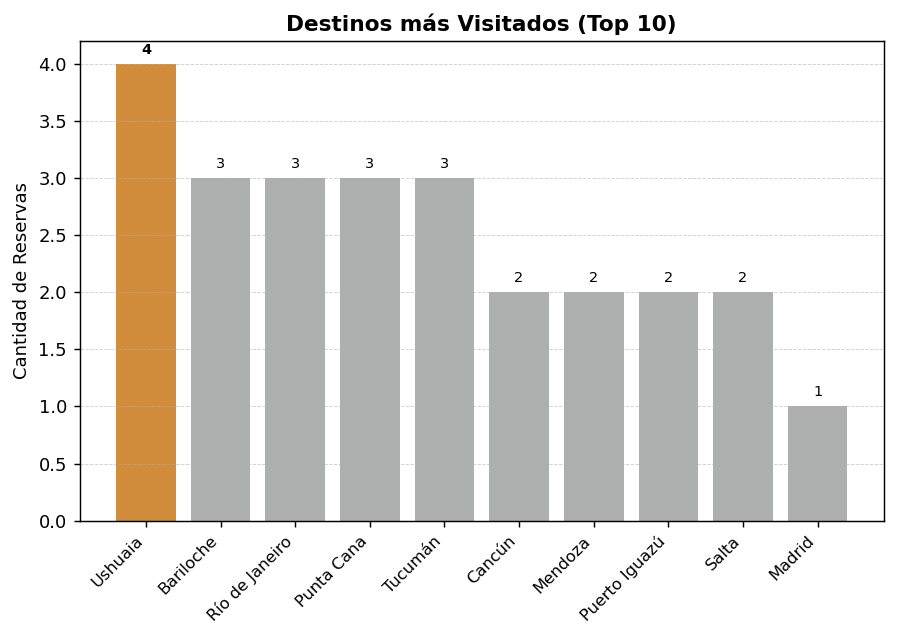

In [143]:
# ---------- 1) Destino más visitado ----------

# Usamos Neo4j contando relaciones VISITO por destino.

def calcular_destinos_mas_visitados(top_n=10):
    """
    Calcula los destinos más visitados según un DataFrame de visitas.

    Esta función resume el número de visitas por destino, ordena de mayor a menor
    y devuelve los destinos más populares. Se usa como helper para consultas
    de recomendaciones y análisis descriptivo.

    Args:
        df_visitas (pandas.DataFrame): Debe contener una columna 'Destino ID'.
        top_n (int, optional): Cantidad de destinos a devolver. Defaults to 5.

    Returns:
        pandas.DataFrame: DataFrame con columnas ['Destino ID', 'Visitas'] ordenado.
    """
    q = """
        MATCH (u:Usuario)-[:VISITO]->(d:Destino)
        RETURN d.destino_id AS destino_id, d.ciudad AS ciudad, count(u) AS cantidad
        ORDER BY cantidad DESC
        """
    with neo4j_driver.session() as s:
        res = s.run(q)
        destinos_agg = [{"_id": r["destino_id"], "cantidad": r["cantidad"], "ciudad": r["ciudad"]} for r in res]

    df = pd.DataFrame([{"destino_id": d["_id"], "ciudad": d.get("ciudad", f"destino_{d['_id']}"), "cantidad": d["cantidad"]} for d in destinos_agg])
    df = df.sort_values("cantidad", ascending=False).head(top_n).reset_index(drop=True)

    return df

df_destinos = calcular_destinos_mas_visitados(top_n=10)

# ---------- 1.A Gráfico: barra (conteo por destino) ----------
if not df_destinos.empty:
    # Aseguramos que el DataFrame esté limitado al Top 10 y ordenado
    df_destinos_plot = df_destinos.sort_values(by="cantidad", ascending=False).head(10)

    # 1. Definir Colores de Destaque
    color_base_pastel = "#AEB0B0"   # Gris Azulado Pastel
    color_destaque_pastel = "#D18C3C" # Rosa Pastel (para el más visitado)
    
    # Crear la lista de colores: todo con el base, excepto el índice 0 (el más visitado)
    colores = [color_base_pastel] * len(df_destinos_plot)
    colores[0] = color_destaque_pastel
    
    # Mostrar el mensaje de destaque
    destino_top = df_destinos_plot.loc[df_destinos_plot.index[0], "ciudad"]
    visitas_top = df_destinos_plot.loc[df_destinos_plot.index[0], "cantidad"]
    print(f"✅ El destino más visitado es **{destino_top}**, con {visitas_top:,} reservas.")

    plt.figure(figsize=(7, 5), dpi=130)
    
    # 2. Generar el gráfico de barras usando la lista de colores
    bars = plt.bar(df_destinos_plot["ciudad"], df_destinos_plot["cantidad"], color=colores)
    
    # 3. Añadir etiquetas de datos
    for i, rect in enumerate(bars):
        height = rect.get_height()
        # Muestra el valor con separador de miles
        plt.annotate(f"{int(height):,}",
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 4), 
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8,
                     # Negrita para el destino más visitado (índice 0)
                     fontweight='bold' if i == 0 else 'normal') 
        
    plt.xticks(rotation=45, ha="right", size=9)
    plt.ylabel("Cantidad de Reservas", size=10)
    
    plt.title(f"Destinos más Visitados (Top {len(df_destinos_plot)})", size=12, fontweight='bold')
    
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    
    plt.tight_layout()
    plt.show()


✅ El hotel más económico es Altos del Norte. Valor Base = $60,000. Se encuentra en la ciudad de Salta.


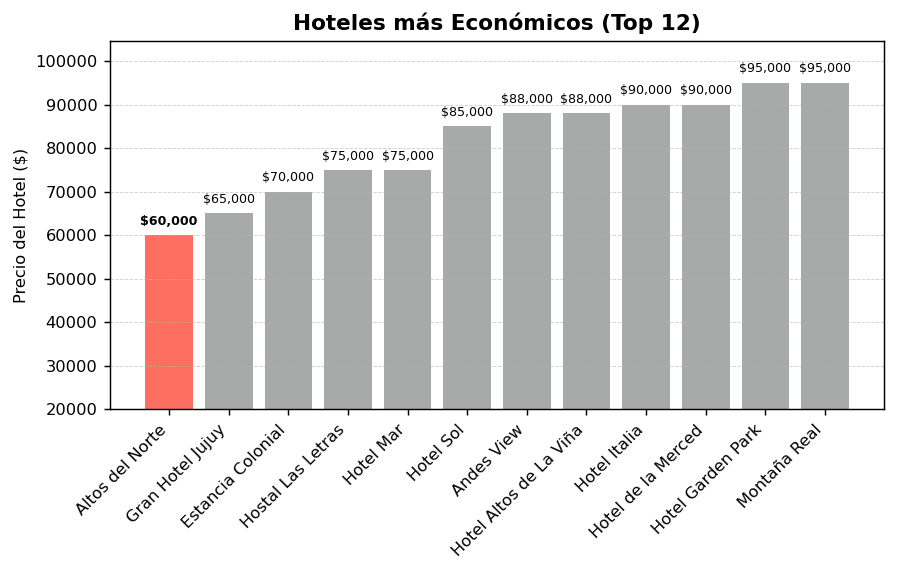

In [144]:
# ---------- 2) Hotel más barato ----------
# Buscamos el hotel con menor precio en la colección 'hoteles' de MongoDB
def obtener_hotel_mas_barato(top_n):
    """
    Devuelve el hotel con menor precio para un destino dado.

    Args:
        destino_id (int): ID del destino.
        mongo_col (Collection): Colección de hoteles en MongoDB.

    Returns:
        dict | None: Documento del hotel más barato o None si no hay resultados.
    """
    # Obtengo los hoteles ordenados por precio ascendente, limitando a top_n
    cursor = db.hoteles.find(
        {}, {"_id":0, "hotel_id":1, "nombre":1, "destino_id":1, "precio":1}
    ).sort("precio", 1).limit(top_n)
    docs = list(cursor)
    if not docs:
        return pd.DataFrame()
    df = pd.DataFrame(docs)
    return df

df_hoteles_baratos = obtener_hotel_mas_barato(top_n=12)

# ---------- 2.A Gráfico: barras (hoteles, destacar el más barato) ----------
if df_hoteles_baratos.empty:
    print("⚠️ No hay datos de hoteles para graficar.")
else:
    # 1. Localizar el más barato y su ciudad
    idx_min = df_hoteles_baratos["precio"].idxmin()
    min_hotel = df_hoteles_baratos.loc[idx_min, "nombre"]
    min_precio = df_hoteles_baratos.loc[idx_min, "precio"]
    min_id = df_hoteles_baratos.loc[idx_min, "destino_id"]

    ciudad_nombre = DESTINO_ID_A_CIUDAD.get(min_id, "Desconocida") 
    
    print(f"✅ El hotel más económico es {min_hotel}. Valor Base = ${min_precio:,.0f}. Se encuentra en la ciudad de {ciudad_nombre}.")

    # 2. Crear figura más compacta
    plt.figure(figsize=(7, 4.5), dpi=130)
    
    # 3. Definir colores: destacar el más barato
    colores = np.array(["#A8A9A9"] * len(df_hoteles_baratos))  # Azul pastel claro
    colores[idx_min] = '#FF6F61'  # Rojo coral para el más barato

    # 4. Crear gráfico de barras
    bars = plt.bar(df_hoteles_baratos["nombre"], df_hoteles_baratos["precio"], color=colores)
    
    # 5. Etiquetas de precios encima de cada barra
    for i, rect in enumerate(bars):
        h = rect.get_height()
        plt.annotate(f"${int(h):,}",
                     xy=(rect.get_x() + rect.get_width()/2, h),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha="center", va="bottom",
                     fontsize=7,
                     fontweight='bold' if i == idx_min else 'normal')

    # 🔹 Ajustar eje Y para que empiece en 20.000
    y_min = 20000
    y_max = df_hoteles_baratos["precio"].max() * 1.1 
    plt.ylim(y_min, y_max)

    # 6. Etiquetas y estética
    plt.xticks(rotation=45, ha="right", fontsize=9)
    plt.ylabel("Precio del Hotel ($)", size=9)
    plt.title(f"Hoteles más Económicos (Top {len(df_hoteles_baratos)})", size=12, fontweight='bold')
    plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

✅ La actividad más popular es **Trekking a Laguna Esmeralda**. Cantidad de Reservas = **4**.


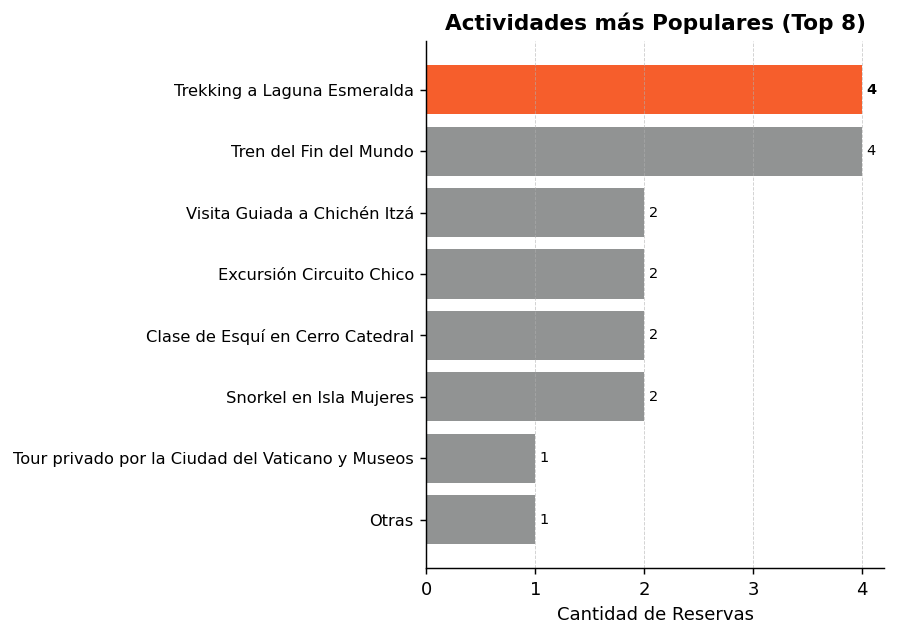

In [145]:
def calcular_actividad_mas_popular():
    """Calcula la popularidad de actividades contando las reservas a partir del array 'actividades_ids' en la colección 'reservas' (MongoDB)."""
    
    pipeline = [
        # 1. Desplegar el array: crea un documento por cada actividad_id
        {"$unwind": "$actividades_ids"}, 
        # 2. Agrupar por la actividad (ahora expuesta) y contar
        {"$group": {"_id": "$actividades_ids", "cantidad": {"$sum": 1}}},
        # 3. Ordenar
        {"$sort": {"cantidad": -1}}
    ]
    
    # Ejecutar la agregación
    agg = list(db.reservas.aggregate(pipeline)) 
    
    if not agg:
        return pd.DataFrame()
    actividades_map = {
        a["actividad_id"]: a["nombre"] 
        for a in db.actividades.find({}, {"_id":0,"actividad_id":1,"nombre":1})
    }
    
    df = pd.DataFrame([{
        "actividad_id": a["_id"],
        "cantidad": a["cantidad"],
        "nombre": actividades_map.get(a["_id"], f"act_{a['_id']}")
    } for a in agg])
    
    return df[['actividad_id', 'nombre', 'cantidad']]

df_actividades_pop = calcular_actividad_mas_popular()

# ---------- Gráfico: barras horizontales (actividades más populares) ----------
valores = df_actividades_pop["cantidad"].astype(int)
etiquetas = df_actividades_pop["nombre"]

# --- 1. Lógica de Agrupación 
top_k = 7 
valores_top = valores[:top_k]
etiquetas_top = etiquetas[:top_k]
    
indice_a_destacar = 0
    
if len(valores) > top_k:
    restantes_sum = valores[top_k:].sum()
    if restantes_sum > 0:
        etiquetas = etiquetas_top.tolist() + ["Otras"]
        valores = valores_top.tolist() + [restantes_sum]
    else: 
        etiquetas, valores = etiquetas_top, valores_top
else:
    etiquetas, valores = etiquetas_top, valores_top

# La actividad más popular es la primera fila (índice 0)
actividad_mas_popular = df_actividades_pop.loc[0, "nombre"]
cantidad_reservas = df_actividades_pop.loc[0, "cantidad"]
   
# 2. Definición de Colores
color_base_pastel = "#919393"  
color_destaque_pastel = "#F65E2C" 
   
# Inicializar todos los colores con el color base
colores_personalizados = [color_base_pastel] * len(valores)
colores_personalizados[indice_a_destacar] = color_destaque_pastel
   
# Invertir el orden para que la más popular quede arriba en el gráfico barh
valores.reverse()
etiquetas.reverse()
colores_personalizados.reverse()
 
print(f"✅ La actividad más popular es **{actividad_mas_popular}**. Cantidad de Reservas = **{cantidad_reservas:,}**.")
    
# --- 3. Gráfico de Barras Horizontal (MEJORA DE VISUALIZACIÓN) ---
plt.figure(figsize=(7, 5), dpi=130)
    
# Generar el gráfico de barras horizontales
bars = plt.barh(etiquetas, valores, color=colores_personalizados)
    
# Etiquetas de datos y formato
for i, bar in enumerate(bars):
    # Etiquetas de valor absoluto con formato de miles
    plt.text(bar.get_width()  + np.max(valores) * 0.01, 
        bar.get_y() + bar.get_height()/2, 
        f"{valores[i]:,}", 
        va='center', 
        fontsize=8,
     fontweight='bold' if i == len(valores) - 1 else 'normal') # La barra más popular está al final de la lista invertida
        
plt.xlabel("Cantidad de Reservas", size=10)
plt.title(f"Actividades más Populares (Top {len(etiquetas)})", fontsize=12, fontweight='bold', loc = "center")
   
plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.6)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

# PARTE D: Realizar modificación en los datos

    - Incrementar el precio de las actividades de Tucuman en 5% 
    - Agregar al hotel id=1 el servicio de SPA 
    - Eliminar el destino que desee 
    - Eliminar un usuario que desee 
    - Eliminar las relaciones AMIGO_DE para un usuario que quiera. 

### 🧩 Modificaciones en los datos

Esta parte se dedica a **modificar o actualizar información existente** en la base de datos.  
Las modificaciones pueden involucrar cambios en los datos de destinos, reservas o usuarios.  

👉 Esta sección demuestra la capacidad del sistema para **adaptarse a nuevos datos y mantener la coherencia** entre MongoDB y Neo4j.


## Funciones para modificaciones

In [146]:
def eliminar_usuario(nombre: str):
    """Eliminar un usuario de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    print(f"\n🧹 --- Eliminando Usuario '{nombre}' ---")

    # --- Neo4j ---
    try:
        q = "MATCH (u:Usuario {nombre:$nombre}) DETACH DELETE u"
        query_neo4j(q, {"nombre": nombre})
        print(f"✅ Usuario '{nombre}' eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en Neo4j: {e}")

    # --- MongoDB ---
    try:
        res = db.usuarios.delete_one({"nombre": nombre})
        if res.deleted_count:
            print(f"✅ Usuario '{nombre}' eliminado de MongoDB (Colección Usuarios).")
        else:
            print(f"⚠️ Usuario '{nombre}' no encontrado en MongoDB.")
    except Exception as e:
        print(f"❌ Error al eliminar usuario en MongoDB: {e}")


def eliminar_relaciones_amigo_de(nombre_usuario: str):
    """Eliminar todas las relaciones AMIGO_DE para un usuario específico (Neo4j)."""
    print(f"\n🔗 --- Eliminando relaciones AMIGO_DE de '{nombre_usuario}' ---")

    try:
        q = """
        MATCH (u:Usuario {nombre: $nombre_usuario})-[r:AMIGO_DE]-() 
        DELETE r
        """
        query_neo4j(q, {"nombre_usuario": nombre_usuario})
        print(f"✅ Todas las relaciones AMIGO_DE de '{nombre_usuario}' han sido eliminadas (Neo4j).")
    except Exception as e:
        print(f"❌ Error al eliminar relaciones AMIGO_DE en Neo4j: {e}")


def eliminar_destino(destino_id: int):
    """Eliminar un destino de MongoDB y sus nodos/relaciones en Neo4j (Integrado)."""
    print(f"\n🌍 --- Eliminando Destino ID {destino_id} ---")

    # --- Neo4j ---
    try:
        q = "MATCH (d:Destino {destino_id:$destino_id}) DETACH DELETE d"
        query_neo4j(q, {"destino_id": destino_id})
        print(f"✅ Destino ID {destino_id} eliminado de Neo4j (Nodos y Relaciones).")
    except Exception as e:
        print(f"❌ Error al eliminar destino en Neo4j: {e}")

    # --- MongoDB ---
    try:
        db.hoteles.delete_many({"destino_id": destino_id})
        db.destinos.delete_one({"destino_id": destino_id})
        print(f"✅ Destino ID {destino_id} y hoteles asociados eliminados de MongoDB.")
    except Exception as e:
        print(f"❌ Error al eliminar destino en MongoDB: {e}")


def agregar_servicio_hotel(hotel_id: int, servicio: str):
    """Agregar un servicio a un hotel (MongoDB). Usa $addToSet para evitar duplicados."""
    print(f"\n🏨 --- Agregando servicio '{servicio}' al hotel {hotel_id} ---")

    try:
        res = db.hoteles.update_one(
            {"hotel_id": hotel_id},
            {"$addToSet": {"servicios": servicio}}
        )
        if res.modified_count:
            print(f"✅ Servicio '{servicio}' agregado al hotel {hotel_id} (MongoDB).")
        else:
            print(f"⚠️ No se modificó el hotel {hotel_id} (puede que ya tenga el servicio).")
    except Exception as e:
        print(f"❌ Error al agregar servicio en MongoDB: {e}")


def modificar_precio_actividades(ciudad: str, pct: float):
    """Incrementar precio de actividades en una ciudad por un porcentaje (MongoDB)."""
    print(f"\n💰 --- Modificando precios de actividades en {ciudad} ---")

    try:
        res = db.actividades.update_many(
            {"ciudad": ciudad},
            {"$mul": {"precio": 1 + pct}}
        )
        print(f"✅ Incrementadas {res.modified_count} actividades en {ciudad} en un {pct*100:.1f}%. (MongoDB)")
    except Exception as e:
        print(f"❌ Error al modificar precios en MongoDB: {e}")

## Pruebas

### 🧪 Pruebas de las modificaciones realizadas

Luego de ejecutar las modificaciones, se realizan pruebas para confirmar que los cambios fueron aplicados correctamente.  
Se consultan nuevamente las bases para verificar la persistencia de los datos actualizados y su reflejo en los resultados del sistema.

👉 Estas pruebas son esenciales para **validar la integridad de la información** después de operaciones de escritura o actualización.


In [147]:
# Ejecución de Modificaciones
print("\n--- Modificaciones ---\n")

# a. Incrementar el precio de las actividades de Bariloche en 5%
modificar_precio_actividades("Bariloche", 0.05) 

# b. Agregar al hotel id=1 el servicio de SPA
agregar_servicio_hotel(hotel_id=1, servicio="SPA")

# c. Eliminar el destino que desee (Ejemplo: ID 5)
eliminar_destino(destino_id=5)

# d. Eliminar un usuario que desee (Ejemplo: Lucía Godoy"")
eliminar_usuario("Lucía Godoy")

# e. Eliminar las relaciones AMIGO_DE para un usuario que quiera (Ejemplo: "María García")
eliminar_relaciones_amigo_de("María García")


--- Modificaciones ---


💰 --- Modificando precios de actividades en Bariloche ---
✅ Incrementadas 4 actividades en Bariloche en un 5.0%. (MongoDB)

🏨 --- Agregando servicio 'SPA' al hotel 1 ---
✅ Servicio 'SPA' agregado al hotel 1 (MongoDB).

🌍 --- Eliminando Destino ID 5 ---
✅ Destino ID 5 eliminado de Neo4j (Nodos y Relaciones).
✅ Destino ID 5 y hoteles asociados eliminados de MongoDB.

🧹 --- Eliminando Usuario 'Lucía Godoy' ---
✅ Usuario 'Lucía Godoy' eliminado de Neo4j (Nodos y Relaciones).
✅ Usuario 'Lucía Godoy' eliminado de MongoDB (Colección Usuarios).

🔗 --- Eliminando relaciones AMIGO_DE de 'María García' ---
✅ Todas las relaciones AMIGO_DE de 'María García' han sido eliminadas (Neo4j).


## PARTE F. Cierre de Conexiones
    Se cierran las conexiones a las bases de datos.

### 🔒 Finalización del entorno

En el bloque final se cierran las conexiones con las bases de datos MongoDB y Neo4j,  
asegurando la liberación adecuada de recursos y la finalización ordenada de las sesiones activas.  

👉 Este cierre controlado garantiza la **seguridad y estabilidad del entorno de ejecución**, evitando errores o bloqueos en futuras ejecuciones.


In [148]:
if neo4j_driver:
    neo4j_driver.close()
if mongo_client:
    mongo_client.close()
if redis_client:
    redis_client.close()
print("🔒 Conexiones cerradas correctamente.")

🔒 Conexiones cerradas correctamente.
